#### 📥 Librerías:

In [14]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

### 📌 Parte 1: Preparación de Datos y Desarrollo del Modelo

✅ *Hemos descargado y guardado los datos en el archivo* `data/NVDA_10yr.csv`.  
El siguiente paso es normalizar la columna `Close` para preparar los datos para el modelo LSTM.


### 🎹 Paso 2: Normalización de datos
Para preparar los datos para la red LSTM, normalizaremos la columna `Close` usando `MinMaxScaler`, escalando los valores entre 0 y 1.

Guardaremos tanto los datos normalizados como el objeto `scaler` para reutilizarlo más adelante.

In [11]:
#  Cargar CSV con MultiIndex en columnas
df = pd.read_csv("data/NVDA_10yr.csv", header=[0, 1], index_col=0, parse_dates=True)

#  Eliminar MultiIndex: nos quedamos con el primer nivel del encabezado
df.columns = df.columns.get_level_values(0)

#  Normalizar la columna 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df[["Close"]])

#  Guardar el scaler para reutilizarlo después
joblib.dump(scaler, "data/close_price_scaler.save")

#  Agregar columna normalizada al DataFrame
df["Close_Scaled"] = scaled_close

#  Mostrar un preview de los datos normalizados
df[["Close", "Close_Scaled"]].head(10)

Price,Close,Close_Scaled
Date,,
2014-01-02,0.373906,0.000079
2014-01-03,0.369427,0.000049
2014-01-06,0.374377,0.000083
2014-01-07,0.380507,0.000124
2014-01-08,0.385694,0.000159
2014-01-09,0.371313,0.000062
2014-01-10,0.370841,0.000059
2014-01-13,0.362118,0.000000
2014-01-14,0.373434,0.000076


 *La columna `Close` ha sido normalizada y guardamos el scaler en* `data/close_price_scaler.save`.  
Ahora toca hacer son **las secuencias de datos** para alimentar el modelo LSTM.


### 🩻 Paso 3: Crear secuencias para LSTM

Las redes requieren datos en forma de secuencias para capturar dependencias temporales. Usaremos un *look-back window* de **60 días**, lo que significa que el modelo utilizará los 60 precios anteriores para predecir el siguiente.

También dividiremos los datos en conjuntos de entrenamiento y prueba manteniendo el orden temporal (`shuffle=False`).

In [13]:
#  Definir función para crear secuencias
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#  Extraer la columna normalizada
scaled_data = df["Close_Scaled"].values.reshape(-1, 1)

#  Crear secuencias
look_back = 60
X, y = create_sequences(scaled_data, look_back=look_back)

#  Redimensionar X para LSTM: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

#  Mostrar shapes
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

#  Dividir en entrenamiento y prueba (80% / 20%, sin shuffle)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)


Shape de X: (2707, 60, 1)
Shape de y: (2707,)
Shape X_train: (2165, 60, 1)
Shape X_test : (542, 60, 1)


### 🧠Paso 4: Construcción del modelo LSTM

Crearemos dos arquitecturas de red neuronal:

1. 🔹 *Modelo sencillo:* una capa LSTM con Dropout para prevenir overfitting y una capa Dense de salida.
2. 🔹 *Modelo robusto:* dos capas LSTM apiladas con Dropout y una capa Dense.

Usaremos `Keras` con TensorFlow como backend.

### 🔹 Modelo 1: Sencillo (1 LSTM)

In [15]:
#  Construir el modelo sencillo
model_simple = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)  # Capa de salida
])

#  Compilar el modelo
model_simple.compile(optimizer="adam", loss="mean_squared_error")

#  Resumen del modelo
model_simple.summary()


/Users/carlosmoreno/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### 🔹 Modelo 2: Robusto (2 LSTM)

In [16]:
# 📦 Construir el modelo robusto
model_robust = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Capa de salida
])

# 🛠 Compilar el modelo
model_robust.compile(optimizer="adam", loss="mean_squared_error")

# 📃 Resumen del modelo
model_robust.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

En el siguiente paso entrenaremos ambos modelos y compararemos sus predicciones con los valores reales.

### Paso 5: Entrenamiento de los modelos y predicción

Entrenaremos ambos modelos (sencillo y robusto) con los datos de entrenamiento durante 50 épocas. Posteriormente, generaremos las predicciones sobre el conjunto de prueba y desnormalizaremos los valores para compararlos con los precios reales.

In [17]:
# Entrenamiento del modelo sencillo
history_simple = model_simple.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Entrenamiento del modelo robusto
history_robust = model_robust.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3542e-04 - val_loss: 0.0012
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9816e-05 - val_loss: 0.0015
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7418e-05 - val_loss: 0.0013
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6495e-05 - val_loss: 0.0021
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6215e-05 - val_loss: 0.0024
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1742e-05 - val_loss: 0.0014
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1236e-05 - val_loss: 0.0030
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9913e-05 - val_loss: 0.0016
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6031e-05 - val_loss: 0.0013
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6332e-05 - val_loss: 0.0019
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3520e-05 - val_loss: 0.0018
Epoch 12/50
68/68 ━━━━━━━━━━━━

### Generar predicciones y desnormalizar

In [20]:
# Predicciones con cada modelo
y_pred_simple = model_simple.predict(X_test)
y_pred_robust = model_robust.predict(X_test)

# Desnormalizar los valores (revertir MinMaxScaler)
import joblib
scaler = joblib.load("data/close_price_scaler.save")

# Desnormalizar predicciones
y_pred_simple_rescaled = scaler.inverse_transform(y_pred_simple)
y_pred_robust_rescaled = scaler.inverse_transform(y_pred_robust)

# Desnormalizar precios reales
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


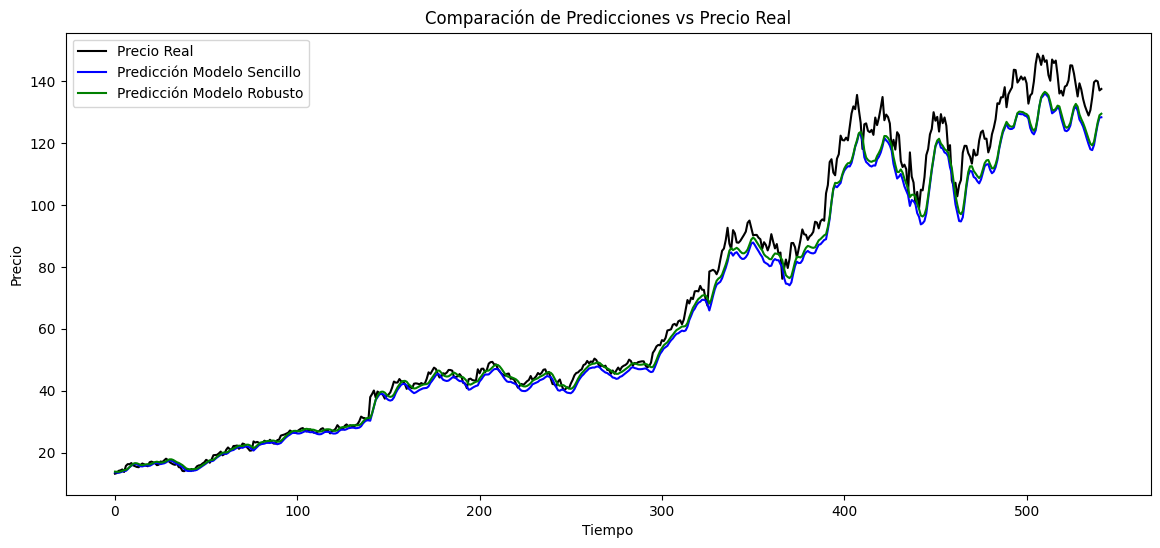

In [21]:
#  Gráfico de comparación
plt.figure(figsize=(14, 6))

# Precios reales
plt.plot(y_test_rescaled, color="black", label="Precio Real")

# Modelo sencillo
plt.plot(y_pred_simple_rescaled, color="blue", label="Predicción Modelo Sencillo")

# Modelo robusto
plt.plot(y_pred_robust_rescaled, color="green", label="Predicción Modelo Robusto")

plt.title("Comparación de Predicciones vs Precio Real")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()


📌 **Finding: Evaluación de predicciones de los modelos LSTM**

En la visualización se observa que **ambos modelos (sencillo y robusto)** logran seguir de manera adecuada la tendencia general de los precios reales de NVIDIA a lo largo del periodo de prueba.  

🔹 El **modelo robusto** (2 capas LSTM) muestra predicciones **más cercanas a los valores reales**, especialmente en los picos y valles. 

🔹 El **modelo sencillo** tiende a suavizar las variaciones, generando predicciones ligeramente más atrasadas respecto a los cambios bruscos en los precios.  

    Aunque ambos modelos son efectivos, la arquitectura robusta tiene un mejor desempeño al capturar movimientos más abruptos, lo cual podría traducirse en decisiones de trading más acertadas.


### Paso 6: Backtesting de estrategias

Para evaluar el rendimiento práctico de los modelos, simularemos una estrategia de trading simple:
  
- **Estrategia LSTM:** Comprar cuando la predicción del próximo precio sea mayor que el precio actual (señal de subida). Vender cuando la predicción sea menor que el precio actual (señal de bajada). 

- **Estrategia Buy & Hold:** Comprar una vez al inicio y mantener la posición durante todo el periodo.

In [31]:
#  Simulación de estrategia de trading
def backtest_strategy(predictions, real_prices):
    """
    Simula una estrategia de trading:
    - Compra cuando la predicción futura > precio actual.
    - Vende cuando la predicción futura < precio actual.
    """
    returns = []
    position = 0  # 0 = no posición, 1 = comprado

    for i in range(1, len(real_prices)):
        if predictions[i] > real_prices[i-1] and position == 0:
            position = 1  # Comprar
        elif predictions[i] < real_prices[i-1] and position == 1:
            position = 0  # Vender

        # Calcular retorno diario
        daily_return = (real_prices[i] / real_prices[i-1] - 1) * position
        returns.append(daily_return)

    # Retorno acumulado
    cumulative_return = np.cumprod([1 + r for r in returns])
    return cumulative_return

#  Simular ambas estrategias
real_prices = y_test_rescaled.flatten()

# Estrategia LSTM Sencilla
returns_simple = backtest_strategy(y_pred_simple_rescaled.flatten(), real_prices)

# Estrategia LSTM Robusta
returns_robust = backtest_strategy(y_pred_robust_rescaled.flatten(), real_prices)

# Estrategia Buy & Hold
buy_hold = real_prices / real_prices[0]


 *Hemos simulado una estrategia de trading basada en predicciones LSTM y la comparamos con Buy & Hold.*  
El siguiente paso será guardar los modelos y scaler para reutilizarlos posteriormente. Sin embargo, pensamos que es posible probarlo de una manera más práctica. Hagamos un miniback tester con la finalidad de probar con un 💰 `capital inicial` el desempeño de los modelos.


In [32]:
def mini_backtester(predictions, real_prices, capital_inicial=10000):
    """
    Simula una estrategia de trading simple:
    - Compra cuando la predicción futura > precio actual.
    - Vende cuando la predicción futura < precio actual.
    """
    capital = capital_inicial
    position = 0  # 0 = no posición, 1 = comprado
    shares = 0
    capital_history = []
    trade_signals = []  # Para registrar señales (Buy/Sell)

    for i in range(1, len(real_prices)):
        price_today = real_prices[i]
        price_yesterday = real_prices[i-1]

        # Estrategia: comprar si la predicción sube
        if predictions[i] > price_yesterday and position == 0:
            shares = capital // price_today  # Comprar acciones enteras
            capital -= shares * price_today
            position = 1
            trade_signals.append(("Buy", i, price_today))

        # Estrategia: vender si la predicción baja
        elif predictions[i] < price_yesterday and position == 1:
            capital += shares * price_today  # Vender todas las acciones
            shares = 0
            position = 0
            trade_signals.append(("Sell", i, price_today))

        # Registrar el valor total del portafolio
        portfolio_value = capital + shares * price_today
        capital_history.append(portfolio_value)

    # Valor final si aún hay posición abierta
    if position == 1:
        capital += shares * price_today
        trade_signals.append(("Sell", len(real_prices)-1, real_prices[-1]))
        shares = 0

    return np.array(capital_history), trade_signals


In [33]:
capital_history, trades = mini_backtester(
    preds=y_pred_robust_rescaled.flatten(),
    real_prices=y_test_rescaled.flatten(),
    initial_capital=1000
)

# Mostrar resumen de operaciones
for t in trades[-5:]:
    print(f"{t[0]} @ Día {t[1]} | Precio: {t[2]:.2f} | Capital: {t[3]:.2f}")

print(f"\nCapital final: ${capital_history[-1]:.2f}")


TypeError: mini_backtester() got an unexpected keyword argument 'preds'

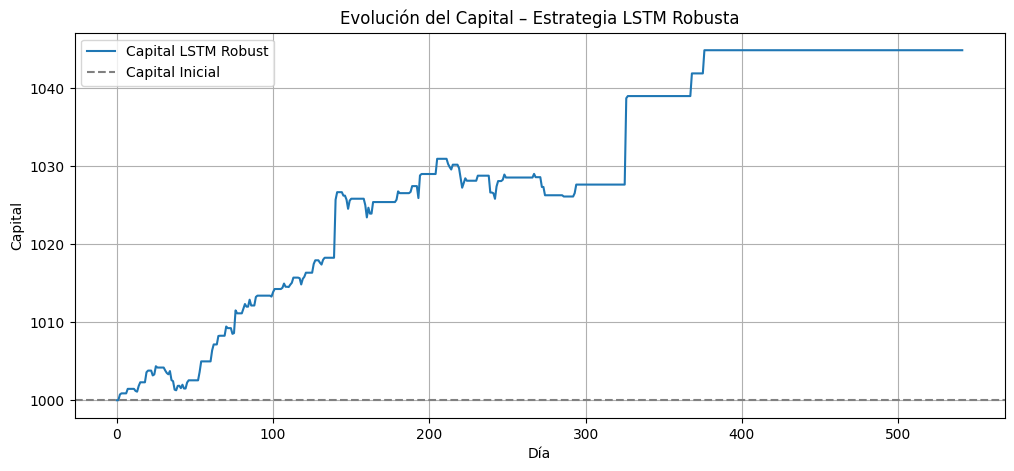

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(capital_history, label="Capital LSTM Robust")
plt.axhline(1000, color='gray', linestyle='--', label="Capital Inicial")
plt.title("Evolución del Capital – Estrategia LSTM Robusta")
plt.xlabel("Día")
plt.ylabel("Capital")
plt.legend()
plt.grid(True)
plt.show()


### 📍 Visualización Pro: Entradas y salidas en el precio

Graficaremos los precios reales y señalaremos las operaciones:  
🔵 Flechas hacia arriba para compras (Buy).  
🔴 Flechas hacia abajo para ventas (Sell).  


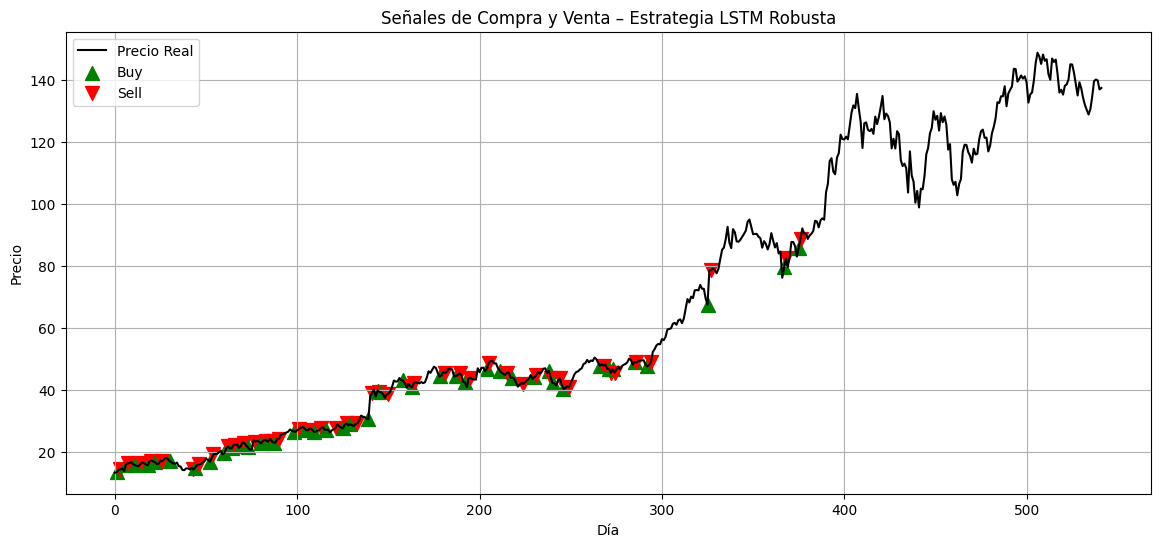

In [35]:
def plot_trades(real_prices, trades):
    plt.figure(figsize=(14, 6))
    plt.plot(real_prices, color="black", label="Precio Real")
    
    # Marcar las operaciones
    for t in trades:
        if t[0] == "Buy":
            plt.scatter(t[1], t[2], color="green", marker="^", s=100, label="Buy")
        elif t[0] == "Sell":
            plt.scatter(t[1], t[2], color="red", marker="v", s=100, label="Sell")
    
    plt.title("Señales de Compra y Venta – Estrategia LSTM Robusta")
    plt.xlabel("Día")
    plt.ylabel("Precio")
    plt.legend(["Precio Real", "Buy", "Sell"])
    plt.grid(True)
    plt.show()

# 📊 Visualizar operaciones sobre el precio
plot_trades(y_test_rescaled.flatten(), trades)


### 💵Comparación: LSTM vs Buy & Hold (Crecimiento de capital)

Compararemos el crecimiento acumulado del portafolio usando:  
- 📈 **Estrategia LSTM (robusto)**: compra y venta según las predicciones.  
- 📊 **Buy & Hold**: comprar al inicio y mantener hasta el final.

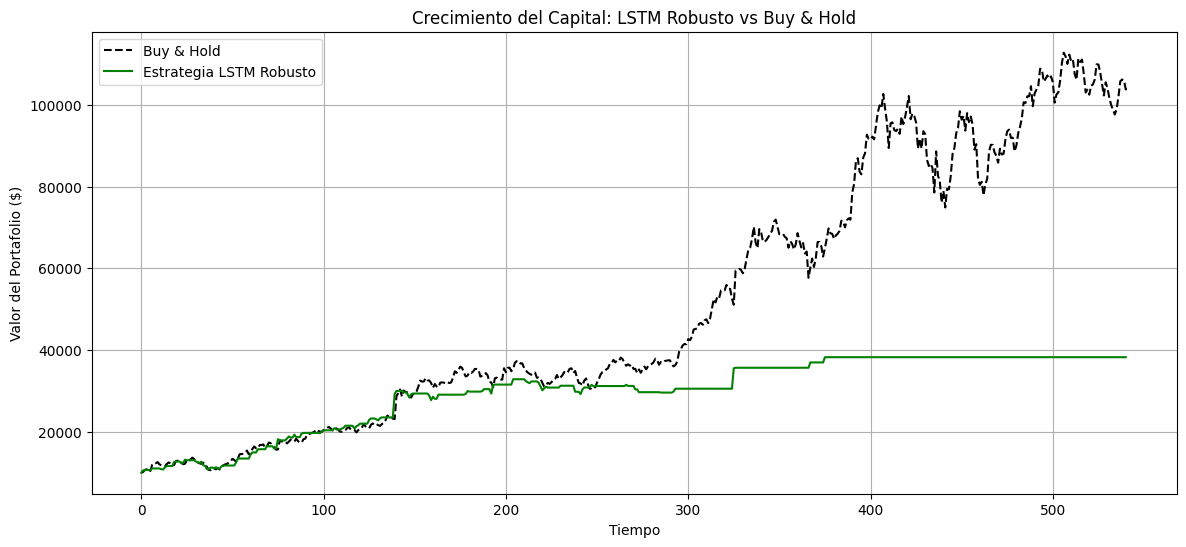

In [36]:
# 📈 Buy & Hold
capital_initial = 10000
buy_hold_value = real_prices / real_prices[0] * capital_initial  # Normalizado al capital inicial

# 📈 LSTM Robusto (corregido)
capital_history_robust, trade_signals_robust = mini_backtester(
    y_pred_robust_rescaled.flatten(),
    real_prices,
    capital_initial  # Pasar como argumento posicional
)

plt.figure(figsize=(14, 6))
plt.plot(buy_hold_value, label="Buy & Hold", color="black", linestyle="--")
plt.plot(capital_history_robust, label="Estrategia LSTM Robusto", color="green")

plt.title("Crecimiento del Capital: LSTM Robusto vs Buy & Hold")
plt.xlabel("Tiempo")
plt.ylabel("Valor del Portafolio ($)")
plt.legend()
plt.grid(True)
plt.show()



✅ *El gráfico muestra la evolución del capital para ambas estrategias a lo largo del tiempo. La línea discontinua negra representa la estrategia Buy & Hold, mientras que la línea verde corresponde a la estrategia basada en LSTM (robusto).*  
